# MBA obfuscation

In [1]:
# Original expression
# ---
# (x | y) + (x ^ y)

# MBA rewrite rules
# ---
# x | y -> x + (~x & y)
# x ^ y -> x + y - 2*(x & y)
# x + y -> (x | y) + (~x | y) - ~x

# Pairs of inverse permutation polynomials
# ---
# P1(X) = 2155511622373988895 + 16804540376168033095*X + 17386697504552124416*X*X
# Q1(X) = 14474691768414218647 + 7223014174769139319*X + 18246968630623338496*X*X
#
# P2(X) = 4368369358058645032 + 18201185361712082273*X + 14550288483659808768*X*X
# Q2(X) = 13203382768830271704 + 10131431409256887969*X + 12017493690218971136*X*X
#
# P3(X) = 17188393767951940199 + 10441007794851070987*X + 8046993899073306624*X*X
# Q3(X) = 13473451123818078059 + 3398791266673272739*X + 13243469762442297344*X*X

In [2]:
import ast
from showast import show_ast
from z3 import *
set_option(max_lines=1, max_width=10000000, max_args=10000000, max_depth=10000000, max_visited=10000000)

x, y = BitVecs('x y', 64)
X = BitVec('X', 64)

In [3]:
original_expr = "(x | y) + (x ^ y)"

In [4]:
"""
Prove the semantic equivalence of the operators
and their rewritten (more complex) form.
In other words, prove the correctness of the
MBA rewrite rules.
"""
mba_or  = "x + (~x & y)"
mba_xor = "x + y - 2*(x & y)"
mba_add = "(x | y) + (~x | y) - ~x"

prove(x | y == eval(mba_or))
prove(x ^ y == eval(mba_xor))
prove(x + y == eval(mba_add))

proved
proved
proved


In [5]:
"""
Prove that P(X) and Q(X) define inverse mappings
"""

def P1(X): return 2155511622373988895 + 16804540376168033095*X + 17386697504552124416*X*X
def Q1(X): return 14474691768414218647 + 7223014174769139319*X + 18246968630623338496*X*X

def P2(X): return 4368369358058645032 + 18201185361712082273*X + 14550288483659808768*X*X
def Q2(X): return 13203382768830271704 + 10131431409256887969*X + 12017493690218971136*X*X

def P3(X): return 17188393767951940199 + 10441007794851070987*X + 8046993899073306624*X*X
def Q3(X): return 13473451123818078059 + 3398791266673272739*X + 13243469762442297344*X*X

prove(P1(Q1(X)) == X)
prove(P2(Q2(X)) == X)
prove(P3(Q3(X)) == X)

proved
proved
proved


In [6]:
"""
Insert encoding identities through permutation polynomials
applied to the rewrite rules.
"""

mba_or_enc = str(P1(Q1(eval(mba_or))))
mba_xor_enc = str(P2(Q2(eval(mba_xor))))
mba_add_enc = str(P3(Q3(eval(mba_add))))

print(f"mba_or_enc\n---\n{mba_or_enc}\n")
print(f"mba_xor_enc\n---\n{mba_xor_enc}\n")
print(f"mba_add_enc\n---\n{mba_add_enc}\n")

mba_or_enc
---
2155511622373988895 + 16804540376168033095*(14474691768414218647 + 7223014174769139319*(x + (~x & y)) + 18246968630623338496*(x + (~x & y))*(x + (~x & y))) + 17386697504552124416*(14474691768414218647 + 7223014174769139319*(x + (~x & y)) + 18246968630623338496*(x + (~x & y))*(x + (~x & y)))*(14474691768414218647 + 7223014174769139319*(x + (~x & y)) + 18246968630623338496*(x + (~x & y))*(x + (~x & y)))

mba_xor_enc
---
4368369358058645032 + 18201185361712082273*(13203382768830271704 + 10131431409256887969*(x + y - 2*(x & y)) + 12017493690218971136*(x + y - 2*(x & y))*(x + y - 2*(x & y))) + 14550288483659808768*(13203382768830271704 + 10131431409256887969*(x + y - 2*(x & y)) + 12017493690218971136*(x + y - 2*(x & y))*(x + y - 2*(x & y)))*(13203382768830271704 + 10131431409256887969*(x + y - 2*(x & y)) + 12017493690218971136*(x + y - 2*(x & y))*(x + y - 2*(x & y)))

mba_add_enc
---
17188393767951940199 + 10441007794851070987*(13473451123818078059 + 3398791266673272739*((x |

In [7]:
"""
Prove the semantic equivalence of the operators
and their rewriten and encoded form.
"""

prove(x | y == eval(mba_or_enc))
# prove(x ^ y == eval(mba_xor_enc))
# prove(x + y == eval(mba_add_enc))

proved


In [8]:
"""
Define maps of rewrite rules both for the plain transforms
and the encoded transforms.
"""
rw_plain = {
    '|': mba_or,
    '^': mba_xor,
    '+': mba_add
}

rw_enc = {
    '|': mba_or_enc,
    '^': mba_xor_enc,
    '+': mba_add_enc
}

In [9]:
"""
Generate AST representation of the non-obfuscated (simple)
expression we will deal with.
"""
original_expr_ast = ast.parse(original_expr)

In [10]:
print(ast.dump(original_expr_ast.body[0].value, indent=4))

BinOp(
    left=BinOp(
        left=Name(id='x', ctx=Load()),
        op=BitOr(),
        right=Name(id='y', ctx=Load())),
    op=Add(),
    right=BinOp(
        left=Name(id='x', ctx=Load()),
        op=BitXor(),
        right=Name(id='y', ctx=Load())))


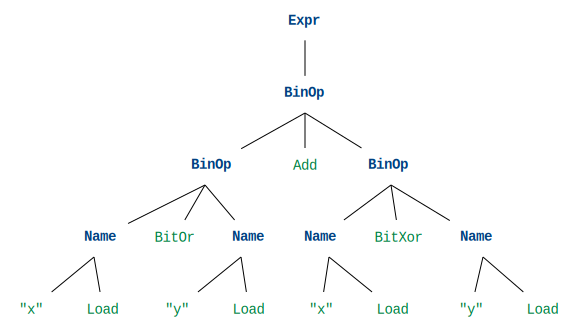

In [11]:
show_ast(original_expr_ast)

In [12]:
"""
Extract binary operations (i.e. operations with two operands)
from the AST representation of the expression, from bottom to top.
"""
def bottomUpBFS(node):
    q = []
    q.append(node)
    
    bin_ops = []
    
    while q:
        cur = q.pop()
        
        if hasattr(cur, 'left'):
            q.append(cur.left)
            
        if hasattr(cur, 'right'):
            q.append(cur.right)
            
        if isinstance(cur, ast.BinOp):
            bin_ops.append(cur)
            
    return bin_ops

In [13]:
"""
Apply MBA rewrite rule
"""
def apply_rewrite_rule(rw, L, R):
    return rw.replace('x', 'L').replace('y', 'R').replace('L', f"({L})").replace('R', f"({R})")

In [14]:
"""
Rewrite rules are applied to the whole (sub)expressions
that conform Left and Right operands for the
binary operations covered (OR, XOR and ADD).
"""
def obfuscate(expr, rw_map, show):
    root = ast.parse(expr)
    
    if show:
        print(expr)
        show_ast(root)
    
    node = root.body[0].value
    bin_ops = bottomUpBFS(node)
    
    while bin_ops:
        cur = bin_ops.pop()
        new = None
        
        L = ast.unparse(cur.left)
        R = ast.unparse(cur.right)
        
        if isinstance(cur.op, ast.BitOr):
            rw = rw_map['|']
            tmp_expr = apply_rewrite_rule(rw, L, R)
            new = ast.parse(tmp_expr).body[0].value
            
        if isinstance(cur.op, ast.BitXor):
            rw = rw_map['^']
            tmp_expr = apply_rewrite_rule(rw, L, R)
            new = ast.parse(tmp_expr).body[0].value
            
        if isinstance(cur.op, ast.Add):
            rw = rw_map['+']
            tmp_expr = apply_rewrite_rule(rw, L, R)
            new = ast.parse(tmp_expr).body[0].value
            
        if new:
            cur.op = new.op
            cur.left = new.left
            cur.right = new.right
            
            if show:
                print(f"{50 * '='}\n")
                print(ast.unparse(root))
                show_ast(root)
                
    return root

(x | y) + (x ^ y)


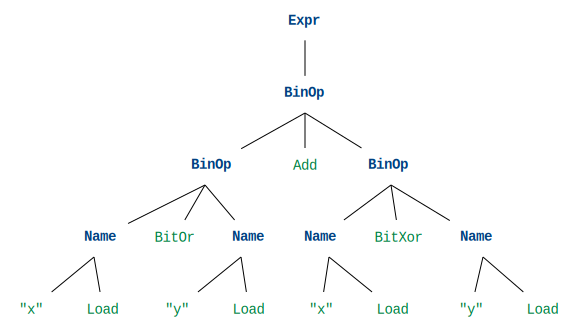


x + (~x & y) + (x ^ y)


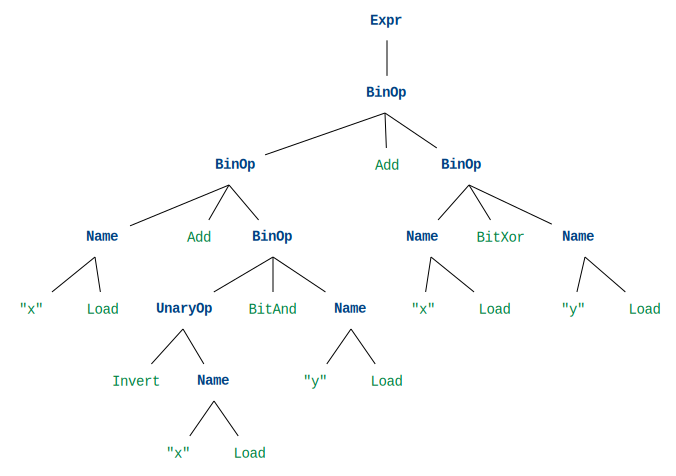


x + (~x & y) + (x + y - 2 * (x & y))


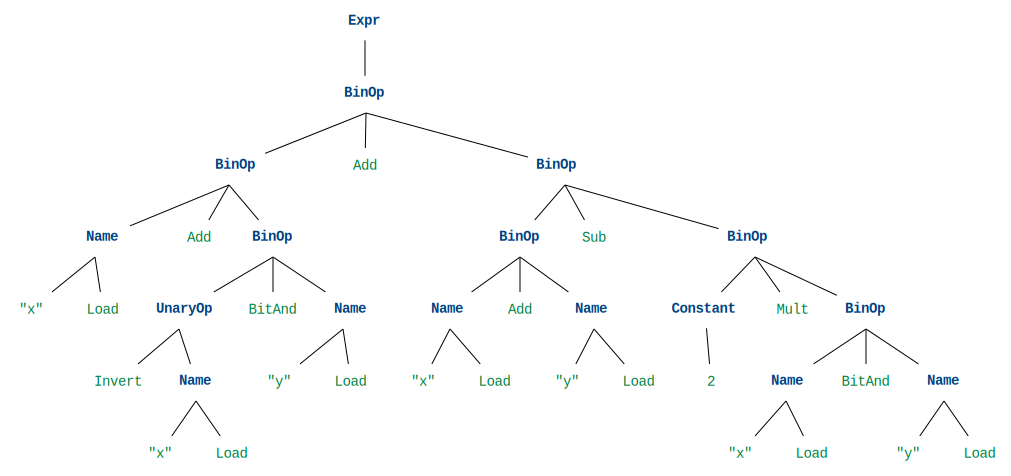


(x + (~x & y) | x + y - 2 * (x & y)) + (~(x + (~x & y)) | x + y - 2 * (x & y)) - ~(x + (~x & y))


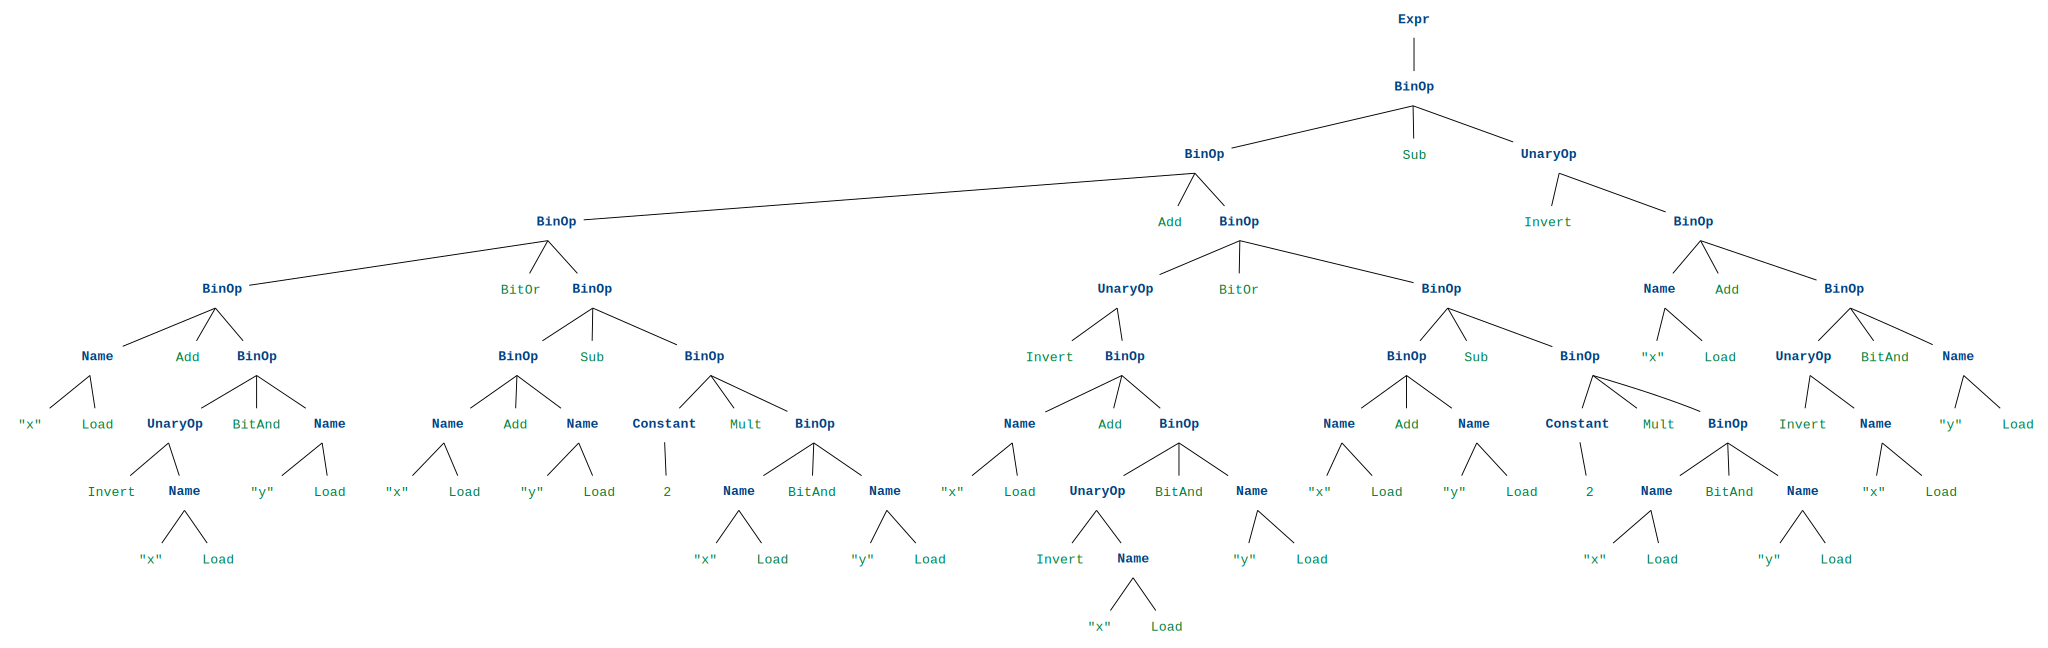

In [15]:
"""
Apply plain rewrite rules
"""
expr_ast = obfuscate(original_expr, rw_plain, True)

In [16]:
obf = ast.unparse(expr_ast)
print(obf)

(x + (~x & y) | x + y - 2 * (x & y)) + (~(x + (~x & y)) | x + y - 2 * (x & y)) - ~(x + (~x & y))


2155511622373988895 + 16804540376168033095*(14474691768414218647 + 7223014174769139319*((x + (~x & y) | x + y - 2*(x & y)) + (~(x + (~x & y)) | x + y - 2*(x & y)) - ~(x + (~x & y))) + 18246968630623338496*((x + (~x & y) | x + y - 2*(x & y)) + (~(x + (~x & y)) | x + y - 2*(x & y)) - ~(x + (~x & y)))*((x + (~x & y) | x + y - 2*(x & y)) + (~(x + (~x & y)) | x + y - 2*(x & y)) - ~(x + (~x & y)))) + 17386697504552124416*(14474691768414218647 + 7223014174769139319*((x + (~x & y) | x + y - 2*(x & y)) + (~(x + (~x & y)) | x + y - 2*(x & y)) - ~(x + (~x & y))) + 18246968630623338496*((x + (~x & y) | x + y - 2*(x & y)) + (~(x + (~x & y)) | x + y - 2*(x & y)) - ~(x + (~x & y)))*((x + (~x & y) | x + y - 2*(x & y)) + (~(x + (~x & y)) | x + y - 2*(x & y)) - ~(x + (~x & y))))*(14474691768414218647 + 7223014174769139319*((x + (~x & y) | x + y - 2*(x & y)) + (~(x + (~x & y)) | x + y - 2*(x & y)) - ~(x + (~x & y))) + 18246968630623338496*((x + (~x & y) | x + y - 2*(x & y)) + (~(x + (~x & y)) | x + y - 2

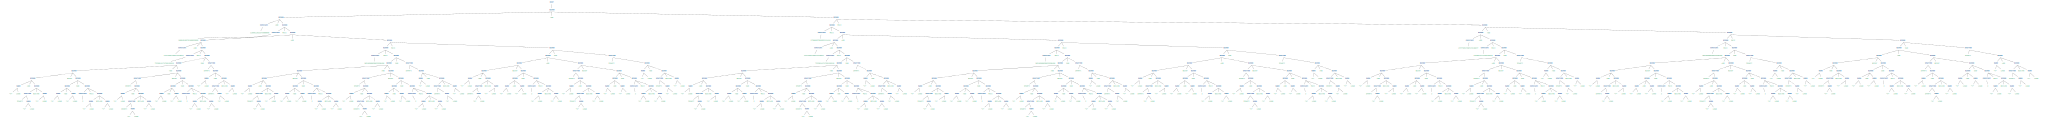

In [17]:
"""
Encode the whole rewritten expression
"""
obf_enc_whole = str(P1(Q1(eval(obf))))
expr_ast = ast.parse(obf_enc_whole)
print(obf_enc_whole)
show_ast(expr_ast)

In [18]:
"""
Apply already encoded rewrite rules
"""

expr_ast = obfuscate(original_expr, rw_enc, False)

In [19]:
obf_enc_terms = ast.unparse(expr_ast)
print(obf_enc_terms)

17188393767951940199 + 10441007794851070987 * (13473451123818078059 + 3398791266673272739 * ((2155511622373988895 + 16804540376168033095 * (14474691768414218647 + 7223014174769139319 * (x + (~x & y)) + 18246968630623338496 * (x + (~x & y)) * (x + (~x & y))) + 17386697504552124416 * (14474691768414218647 + 7223014174769139319 * (x + (~x & y)) + 18246968630623338496 * (x + (~x & y)) * (x + (~x & y))) * (14474691768414218647 + 7223014174769139319 * (x + (~x & y)) + 18246968630623338496 * (x + (~x & y)) * (x + (~x & y))) | 4368369358058645032 + 18201185361712082273 * (13203382768830271704 + 10131431409256887969 * (x + y - 2 * (x & y)) + 12017493690218971136 * (x + y - 2 * (x & y)) * (x + y - 2 * (x & y))) + 14550288483659808768 * (13203382768830271704 + 10131431409256887969 * (x + y - 2 * (x & y)) + 12017493690218971136 * (x + y - 2 * (x & y)) * (x + y - 2 * (x & y))) * (13203382768830271704 + 10131431409256887969 * (x + y - 2 * (x & y)) + 12017493690218971136 * (x + y - 2 * (x & y)) * (x 

# Symbolic execution

In [20]:
"""
Adapted from /opt/tools/msynth/scripts/symbolic_simplification.py

Extract the symbolic expression for RAX register in a given
basic block at start_addr.
"""
from miasm.analysis.binary import Container
from miasm.analysis.machine import Machine
from miasm.core.locationdb import LocationDB
from miasm.ir.symbexec import SymbolicExecutionEngine

def getRaxExpr(file_path, start_addr):
    # symbol table
    loc_db = LocationDB()

    # open the binary for analysis
    container = Container.from_stream(open(file_path, 'rb'), loc_db)

    # cpu abstraction
    machine = Machine(container.arch)

    # init disassemble engine
    mdis = machine.dis_engine(container.bin_stream, loc_db=loc_db)

    # initialize intermediate representation
    lifter = machine.lifter_model_call(mdis.loc_db)

    # disassemble the function at address
    asm_block = mdis.dis_block(start_addr)

    # lift to Miasm IR
    ira_cfg = lifter.new_ircfg()
    lifter.add_asmblock_to_ircfg(asm_block, ira_cfg)

    # init symbolic execution engine
    sb = SymbolicExecutionEngine(lifter)

    # symbolically execute basic block
    sb.run_block_at(ira_cfg, start_addr)
    
    # return the expression of rax (return value)
    return sb.eval_exprid(lifter.arch.regs.RAX)

In [21]:
"""
Extract symbolic expression for RAX, with respect to the
input variables (registers RDI and RSI) of the scramble
function in scramble1
"""
file_path = "./scramble1"
addr = 0x1149

rax_scramble1 = getRaxExpr(file_path, addr)
print("RAX from scramble1\n---")
print(rax_scramble1)

RAX from scramble1
---
(RDI ^ RSI) + (RDI | RSI)


In [22]:
"""
Extract symbolic expression for RAX, with respect to the
input variables (registers RDI and RSI) of the scramble
function in scramble2
"""
file_path = "./scramble2"
addr = 0x1149

rax_scramble2 = getRaxExpr(file_path, addr)
print("RAX from scramble2\n---")
print(rax_scramble2)

RAX from scramble2
---
RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | (RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)))) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF))) ^ 0xFFFFFFFFFFFFFFFF)) + 0x1


In [23]:
"""
Extract symbolic expression for RAX, with respect to the
input variables (registers RDI and RSI) of the scramble
function in scramble3
"""
file_path = "./scramble3"
addr = 0x1149

rax_scramble3 = getRaxExpr(file_path, addr)
print("RAX from scramble3\n---")
print(rax_scramble3)

RAX from scramble3
---
(((({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | (RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)))) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF))) ^ 0xFFFFFFFFFFFFFFFF)) + 0x1 0 64, 0x0 64 128} * {RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | (RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)))) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF))) ^ 0xFFFFFFFFFFFFFFFF)) + 0x1 0 64, 0x0 64 128})[0:64] * 0xFD3A414B00000000 + ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | (RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)))) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF))) ^ 0xFFFFFFFFFFFFFFFF)) + 0x1)[63:64]?({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | (RDI + (RSI 

In [24]:
"""
Extract symbolic expression for RAX, with respect to the
input variables (registers RDI and RSI) of the scramble
function in scramble4
"""
file_path = "./scramble4"
addr = 0x1149

rax_scramble4 = getRaxExpr(file_path, addr)
print("RAX from scramble4\n---")
print(rax_scramble4)

RAX from scramble4
---
((((-(((({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128} * {RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128})[0:64] * 0xFD3A414B00000000 + ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)))[63:64]?({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0xFFFFFFFFFFFFFFFF 64 128} * 0x643D4D1F6EB9CE77,{RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128} * 0x643D4D1F6EB9CE77))[0:64] + 0xC8E06F792199A997) * 0xE935B87017346B47 + ({({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128} * {RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128})[0:64] * 0xFD3A414B00000000 + ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)))[63:64]?({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0xFFFFFFFFFFFFFFFF 64 128} * 0x643D4D1F6EB9CE77,{RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128} * 0x643D4D1F6EB9CE77))[0:64] + 0xC8E06F792199A997 0 64, 0x0 64 128} * {({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128} * {RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFF

In [25]:
"""
Load miasm translator to convert miasm expressions into
z3 expressions
"""
from miasm.ir.translators.z3_ir import TranslatorZ3
translator = TranslatorZ3()

In [26]:
"""
Compare RAX expression from symbolic execution with
simplified expression through basic z3's SMT simplification
of the scramble function in scramble1
"""
print(f"Original RAX scramble1:\n---\n{rax_scramble1}\n")

rax_scramble1_z3 = translator.from_expr(rax_scramble1)
print(f"SMT simplified RAX scramble1:\n---\n{simplify(rax_scramble1_z3)}\n")

Original RAX scramble1:
---
(RDI ^ RSI) + (RDI | RSI)

SMT simplified RAX scramble1:
---
(RDI ^ RSI) + (RDI | RSI)



In [27]:
"""
Compare RAX expression from symbolic execution with
simplified expression through basic z3's SMT simplification
of the scramble function in scramble2
"""
print(f"Original RAX scramble2:\n---\n{rax_scramble2}\n")

rax_scramble2_z3 = translator.from_expr(rax_scramble2)
print(f"SMT simplified RAX scramble2:\n---\n{simplify(rax_scramble2_z3)}\n")

Original RAX scramble2:
---
RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | (RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)))) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF))) ^ 0xFFFFFFFFFFFFFFFF)) + 0x1

SMT simplified RAX scramble2:
---
1 + RDI + ~(~RSI | RDI) + (RDI + RSI + 18446744073709551614*~(~RDI | ~RSI) | RDI + ~(~RSI | RDI)) + (RDI + RSI + 18446744073709551614*~(~RDI | ~RSI) | ~(RDI + ~(~RSI | RDI)))



In [28]:
"""
Compare RAX expression from symbolic execution with
simplified expression through basic z3's SMT simplification
of the scramble function in scramble3
"""
print(f"Original RAX scramble3:\n---\n{rax_scramble3}\n")

rax_scramble3_z3 = translator.from_expr(rax_scramble3)
print(f"SMT simplified RAX scramble3:\n---\n{simplify(rax_scramble3_z3)}\n")

Original RAX scramble3:
---
(((({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | (RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)))) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF))) ^ 0xFFFFFFFFFFFFFFFF)) + 0x1 0 64, 0x0 64 128} * {RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | (RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)))) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF))) ^ 0xFFFFFFFFFFFFFFFF)) + 0x1 0 64, 0x0 64 128})[0:64] * 0xFD3A414B00000000 + ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | (RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)))) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF))) ^ 0xFFFFFFFFFFFFFFFF)) + 0x1)[63:64]?({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | (RDI + 

In [29]:
"""
Compare RAX expression from symbolic execution with
simplified expression through basic z3's SMT simplification
of the scramble function in scramble4
"""
print(f"Original RAX scramble4:\n---\n{rax_scramble4}\n")

rax_scramble4_z3 = translator.from_expr(rax_scramble4)
print(f"SMT simplified RAX scramble4:\n---\n{simplify(rax_scramble4_z3)}\n")

Original RAX scramble4:
---
((((-(((({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128} * {RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128})[0:64] * 0xFD3A414B00000000 + ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)))[63:64]?({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0xFFFFFFFFFFFFFFFF 64 128} * 0x643D4D1F6EB9CE77,{RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128} * 0x643D4D1F6EB9CE77))[0:64] + 0xC8E06F792199A997) * 0xE935B87017346B47 + ({({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128} * {RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128})[0:64] * 0xFD3A414B00000000 + ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)))[63:64]?({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0xFFFFFFFFFFFFFFFF 64 128} * 0x643D4D1F6EB9CE77,{RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128} * 0x643D4D1F6EB9CE77))[0:64] + 0xC8E06F792199A997 0 64, 0x0 64 128} * {({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128} * {RDI + (RSI & (RDI ^ 0xFFFFFFFFF

# Program synthesis

In [30]:
"""
Load synthesis Simplifier from msynth tool and
initialize it with given oracle database
"""
from msynth import Simplifier
oracle_path = "/opt/tools/msynth/oracle.pickle"

simplifier = Simplifier(oracle_path)

In [31]:
"""
Compare RAX expression from symbolic execution with
synthesized expression through msynth synthesis
simplification of the scramble function in scramble1
"""
rax_scramble1_synth = simplifier.simplify(rax_scramble1)

print(f"RAX SYMEX scramble1:\n---\n{rax_scramble1}\n")
print(f"RAX SYNTH scramble1:\n---\n{rax_scramble1_synth}\n")

RAX SYMEX scramble1:
---
(RDI ^ RSI) + (RDI | RSI)

RAX SYNTH scramble1:
---
(RDI ^ RSI) + (RDI | RSI)



In [32]:
"""
Compare RAX expression from symbolic execution with
synthesized expression through msynth synthesis
simplification of the scramble function in scramble2
"""
rax_scramble2_synth = simplifier.simplify(rax_scramble2)

print(f"RAX SYMEX scramble2:\n---\n{rax_scramble2}\n")
print(f"RAX SYNTH scramble2:\n---\n{rax_scramble2_synth}\n")

RAX SYMEX scramble2:
---
RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | (RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)))) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF))) ^ 0xFFFFFFFFFFFFFFFF)) + 0x1

RAX SYNTH scramble2:
---
(RDI ^ RSI) + (RDI | RSI)



In [33]:
"""
Compare RAX expression from symbolic execution with
synthesized expression through msynth synthesis
simplification of the scramble function in scramble3
"""
rax_scramble3_synth = simplifier.simplify(rax_scramble3)

print(f"RAX SYMEX scramble3:\n---\n{rax_scramble3}\n")
print(f"RAX SYNTH scramble3:\n---\n{rax_scramble3_synth}\n")

RAX SYMEX scramble3:
---
(((({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | (RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)))) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF))) ^ 0xFFFFFFFFFFFFFFFF)) + 0x1 0 64, 0x0 64 128} * {RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | (RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)))) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF))) ^ 0xFFFFFFFFFFFFFFFF)) + 0x1 0 64, 0x0 64 128})[0:64] * 0xFD3A414B00000000 + ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | (RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)))) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF))) ^ 0xFFFFFFFFFFFFFFFF)) + 0x1)[63:64]?({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) + ((RDI + RSI + (RDI & RSI) * 0xFFFFFFFFFFFFFFFE) | (RDI + (RS

In [34]:
"""
Compare RAX expression from symbolic execution with
synthesized expression through msynth synthesis
simplification of the scramble function in scramble4
"""
rax_scramble4_synth = simplifier.simplify(rax_scramble4)

print(f"RAX SYMEX scramble4:\n---\n{rax_scramble4}\n")
print(f"RAX SYNTH scramble4:\n---\n{rax_scramble4_synth}\n")

RAX SYMEX scramble4:
---
((((-(((({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128} * {RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128})[0:64] * 0xFD3A414B00000000 + ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)))[63:64]?({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0xFFFFFFFFFFFFFFFF 64 128} * 0x643D4D1F6EB9CE77,{RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128} * 0x643D4D1F6EB9CE77))[0:64] + 0xC8E06F792199A997) * 0xE935B87017346B47 + ({({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128} * {RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128})[0:64] * 0xFD3A414B00000000 + ((RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)))[63:64]?({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0xFFFFFFFFFFFFFFFF 64 128} * 0x643D4D1F6EB9CE77,{RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128} * 0x643D4D1F6EB9CE77))[0:64] + 0xC8E06F792199A997 0 64, 0x0 64 128} * {({RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFFFFFF)) 0 64, 0x0 64 128} * {RDI + (RSI & (RDI ^ 0xFFFFFFFFFFFF